# Experiment TE: Analysis code

We have a list of sectors and TIDs which we wish to examine and analyse. Our first step is to import needed modules:

In [2]:
import lightkurve as lk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import List

%matplotlib inline

Next, we will get the TIDs and sectors from the data file.

In [3]:
def download_listed_data(data_path: str) -> List[lk.LightCurve]:
    """Gets data from file and downloads selected curves."""
    # we export the data from the 'data.txt' file containing all our targets
    # the file format assumes data is space separated and header lines are prepended with a # character
    identifiers = []

    for line in open(data_path, "r"):
        if line[0] == "#":  # ignore headers
            continue
        # separate the data on the space and use a dictionary to store each value
        split_line = line.split()
        identifiers.append({"TIC_ID": split_line[0], "Sector_ID": split_line[1]})

    # download each curve and store in list
    downloaded_curves = []

    for index, identifier in enumerate(identifiers):
        print(f"\r{(index/len(identifiers)):.2%}", end="")  # percentage progress
        # get results for each light curve
        # WARNING: this assumes that the result of each search is a single light curve. This is not guaranteed and so if using coordinated outside
        # the provided file this function will need updating.
        search_result = lk.search_lightcurve("TIC " + identifier["TIC_ID"], mission="TESS",
                                             sector=identifier["Sector_ID"], author="SPOC")
        downloaded_curves.append(search_result.download())

    return downloaded_curves

This function returns a list containing each light curve in the file. We test this function by examining the contents of the list.

In [4]:
downloaded_curves = download_listed_data("data.txt")
downloaded_curves[0]

60.61%

96.97%

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2144.520098061748,8.6609492e+04,3.3585510e+01,5.2866386e-03,660283,1380.69925,1552.04544,8.1831531e+04,3.1762281e+01,3.2573933e+03,7.1151600e+00,8.6609492e+04,3.3585510e+01,0,———,———,———,———,1380.69925,3.4068193e-04,1552.04544,3.1621134e-04,3.9759013e-03,2.3963602e-01
2144.5214869989163,8.6672320e+04,3.3594582e+01,5.2866875e-03,660284,1380.69581,1552.04324,8.1876867e+04,3.1770857e+01,3.2598140e+03,7.1087704e+00,8.6672320e+04,3.3594582e+01,0,———,———,———,———,1380.69581,3.4094910e-04,1552.04324,3.1589484e-04,-6.9890748e-04,2.3664325e-01
2144.5228759365496,8.6599305e+04,3.3577213e+01,5.2867369e-03,660285,1380.69677,1552.04601,8.1806031e+04,3.1754431e+01,3.2449756e+03,7.1024718e+00,8.6599305e+04,3.3577213e+01,0,———,———,———,———,1380.69677,3.4096488e-04,1552.04601,3.1642715e-04,5.9107243e-04,2.3987481e-01
2144.524264873717,8.6618641e+04,3.3589130e+01,5.2867858e-03,660286,1380.69700,1552.04469,8.1841242e+04,3.1765703e+01,3.2643992e+03,7.1167808e+00,8.6618641e+04,3.3589130e+01,0,———,———,———,———,1380.69700,3.4061403e-04,1552.04469,3.1610468e-04,5.4778263e-04,2.3855002e-01
2144.525653810886,8.6681531e+04,3.3599777e+01,5.2868347e-03,660287,1380.69721,1552.04411,8.1882500e+04,3.1775774e+01,3.2696914e+03,7.1242237e+00,8.6681531e+04,3.3599777e+01,0,———,———,———,———,1380.69721,3.4073889e-04,1552.04411,3.1625931e-04,1.2685722e-03,2.3806062e-01
2144.527042748055,8.6598539e+04,3.3585590e+01,5.2868836e-03,660288,1380.69587,1552.04494,8.1813570e+04,3.1762354e+01,3.2622949e+03,7.1156988e+00,8.6598539e+04,3.3585590e+01,0,———,———,———,———,1380.69587,3.4090245e-04,1552.04494,3.1622360e-04,-7.0673204e-04,2.3857553e-01
2144.5284316856882,8.6661078e+04,3.3596127e+01,5.2869329e-03,660289,1380.69697,1552.04366,8.1872367e+04,3.1772318e+01,3.2619253e+03,7.1185346e+00,8.6661078e+04,3.3596127e+01,0,———,———,———,———,1380.69697,3.4069785e-04,1552.04366,3.1603934e-04,5.4262485e-04,2.3678996e-01
2144.5298206228567,8.6637812e+04,3.3596420e+01,5.2869818e-03,660290,1380.69526,1552.04583,8.1843117e+04,3.1772596e+01,3.2745764e+03,7.1310396e+00,8.6637812e+04,3.3596420e+01,0,———,———,———,———,1380.69526,3.4078557e-04,1552.04583,3.1634298e-04,-9.1294857e-04,2.4001303e-01


This shows all columns present in the data for the first light curve. We first want to examine this data visually to see if we can spot any obvious phenomena. We first plot a graph for the flux vs time for the first object.

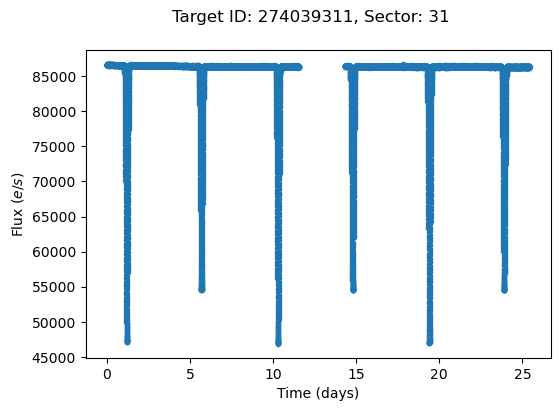

In [5]:
curve = downloaded_curves[0]
curve.flux_err = np.ma.filled(curve.flux_err, fill_value=0.0)  # replace masked values with 0 for error bar
    # this is a bug fix => see section 1.2 of labbook
plt.figure(figsize=(6,4))  # set figure size
plt.errorbar(curve.time.mjd - curve.time[0].mjd, curve.flux, curve.flux_err, fmt='.', ecolor='LightGrey')
plt.suptitle(f"Target ID: {curve.meta['TARGETID']}, Sector: {curve.meta['SECTOR']}")
plt.xlabel("Time (days)")
plt.ylabel("Flux ($e/s$)")
plt.show()

We can see that for this data set the signal is much greater than the noise so it is easy to spot that this is in fact an eclipsing binary. Note the large proportional reduction in flux (ruling out an exoplanet transit), the pattern of smaller and larger obstruction due to the more luminous and less luminous star being obstructed and its periodicity.

Unfortunately this is not true for all of our data sets, so further analysis will be needed. However first we will plot all the graphs and save them to *.pdf* files.

In [6]:
from pathlib import Path


def plot_curve(curve: lk.LightCurve, folder="pics/", save_fig=True, force_create=True, custom_suffix="", x_lim=(0, 0),
               custom_title="", highlight_flags=False, label_flags=False, fig_size=(6, 4)):
    """Plots the LightCurve and saves to a .pdf file

    Parameters
    ----------
    curve : lk.LightCurve
        The light curve to be plotted in the graph. Contains all the information along with the flux to allow for more
        complex plotting.
    folder : string, default="pics/"
        The path to save the pictures to if save_fig=True. This can be a local or system file path.
    save_fig : bool, default=True
        Whether to save the graph or not. Saved to directory 'folder'
    force_create : True, default=True
        Whether to create directory if not exists. This is enabled by default.
    custom_suffix : str, default=""
        Custom addition to end of file when saved to disk. Default is no suffix.
    x_lim : iterable, default=(0,0)
        The bounds to plot the graph on. Default (0, 0) means to use default bounds.
    custom_title : str, default=""
        Custom title to add to the plot.
    highlight_flags : bool, default=False
        Whether to highlight all flagged data points.
    label_flags : bool, default=False
        Whether to color-code and label each flagged region.
    fig_size : iterable, default=(6, 4)
        The size in inches to plot the graph to.
    """
    flag_array = np.array(curve["quality"])
    if force_create:
        Path(folder).mkdir(parents=True, exist_ok=True)  # create if not exists

    curve = curve.normalize().remove_outliers(sigma=10)  # remove +- 10 sigma
    curve.flux_err = np.ma.filled(curve.flux_err, fill_value=0.0)  # replace masked values with 0 for error bar
    # this is a bug fix => see section 1.2 of labbook

    fig, ax = plt.subplots(figsize=fig_size)  # set figure size
    ax.errorbar(curve.time.mjd - curve.time[0].mjd, curve.flux, curve.flux_err, fmt='.', ecolor='LightGrey');
    fig.suptitle(f"Target ID: {curve.meta['TARGETID']}, Sector: {curve.meta['SECTOR']}{custom_title}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Flux (normalised)")

    if highlight_flags:
        start = 0
        flagged = False
        step = (curve.time[-1].mjd - curve.time[0].mjd) / flag_array.shape[0]
        for i in range(flag_array.shape[0]):
            if flag_array[i] != 0 and not flagged:
                flagged = True
                start = i
            elif flag_array[i] == 0 and flagged:
                flagged = False
                ax.axvspan(start * step, i * step, facecolor='r', alpha=0.3)
        if flagged:
            ax.axvspan(start * step, (flag_array.shape[0] - 1) * step, facecolor='r', alpha=0.3)

    if label_flags:
        flags = np.unique(flag_array)[1:]
        flag_dict = {}
        col_dict = {}
        cmap = matplotlib.cm.get_cmap('gist_rainbow')
        for flag in flags:
            flag_dict[flag] = " and ".join(lk.TessQualityFlags.decode(flag))
            col_dict[flag] = cmap(np.where(flags == flag)[0][0] / (len(flags) - 1))

        start = 0
        step = (curve.time[-1].mjd - curve.time[0].mjd) / flag_array.shape[0]
        current_flag = 0
        added_to_legend = {}
        for i in range(flag_array.shape[0]):
            if flag_array[i] != current_flag:
                if current_flag:
                    new_flag_highlight = ax.axvspan(start * step, i * step, facecolor=col_dict[current_flag], alpha=0.7)
                    if current_flag not in added_to_legend:
                        new_flag_highlight.set_label(flag_dict[current_flag])
                        added_to_legend[current_flag] = True
                start = i
                current_flag = flag_array[i]
        if current_flag:
            ax.axvspan(start * step, (flag_array.shape[0] - 1) * step, facecolor=col_dict[current_flag], alpha=0.6)
            if current_flag not in added_to_legend:
                new_flag_highlight.set_label(flag_dict[current_flag])
                added_to_legend[current_flag] = True
        ax.legend()

    if x_lim != (0, 0):
        ax.set_xlim(x_lim)
    if save_fig:
        fig.savefig(
            f"{folder}TIC {curve.meta['TARGETID']}-{curve.meta['SECTOR']}{custom_suffix}.pdf")  # save to 'folder'
    return (fig, ax)


This takes in one *LightCurve* and plots it and saves it to a CSV file with a unique name. We have normalised the plots by dividing by the median flux and remove any data points that are more than 5 sigma (both are inbuilt methods). We have a list of light curves so we create a function to plot for each *LightCurve* in the list.

In [7]:
def plot_curves(curves: list, folder="pics/", save_fig=True):
    """Takes in a list of curves and plots each one to allow us to visually analyse"""
    for index, curve in enumerate(curves):
        print(f"\r{(index/len(curves)):.2%}", end="")  # percentage progress
        temp, _ = plot_curve(curve, folder, save_fig=save_fig)
        plt.close(temp)

We can now plot any number of *lightcurve* objects. We plot for each curve and save them to the "pics" folder.

In [8]:
plot_curves(downloaded_curves)

96.97%

We now have all of our plots saved to *.pdf* files, which allows us to visually inspect the data. We can see some signals clearly already, however some only show noise, which means we need to remove some of this noise to allow us to spot any signal.

We wish to experiment with binning the data, so we create a function to test different bin widths.

In [9]:
def compare_bin_errors(curve: lk.LightCurve, bin_widths: List[float], cut=(0, 0)):
    """Returns a list of dictionaries containing the bin width, std. dev., and mean error"""
    return_data = []  # data to be returned
    cut_index = [0, 0]
    
    for index, bin_width in enumerate(bin_widths):
        print(f"\r{(index/len(bin_widths)):.2%}", end="")  # percentage progress
        if bin_width == 0:  # treat 0 bin width as unchanged data (handles error case)
            return_data.append({"bin_width": bin_width,
                            "std": np.nanstd(curve.flux),
                            "mean_err": np.nanmean(curve.flux_err)})
            continue
        
        binned_curve = curve.bin(time_bin_size=bin_width)

        if cut != (0,0):  # if cut
            cut_index[0] = int(cut[0] / bin_width)
            cut_index[1] = int(cut[1] / bin_width)
            
            cut_flux = binned_curve.flux[cut_index[0]:cut_index[1]-cut_index[0]]
            cut_flux_err = binned_curve.flux_err[cut_index[0]:cut_index[1]-cut_index[0]]
        else:
            cut_flux = binned_curve.flux
            cut_flux_err = binned_curve.flux_err
        
        return_data.append({"bin_width": bin_width,
                            "std": np.nanstd(cut_flux),
                            "mean_err": np.nanmean(cut_flux_err)})
    return return_data

Now we wish to test on a section without any clear signal, so we pick one of the curves and choose a section of it to analyse:

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Time (days)', ylabel='Flux (normalised)'>)

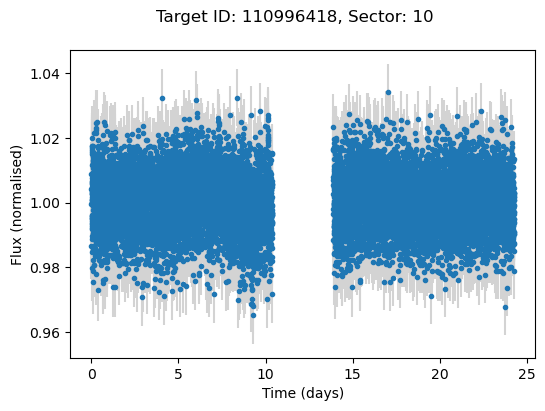

In [10]:
testing_curve = downloaded_curves[16]
plot_curve(testing_curve, save_fig=False)


We will choose the first 10 days to analyse, which appear visually to be purely noise.

66.67%
Bin width 0.05, error 1.1189865353791022 electron / s, std dev 1.2363736058538632 electron / s
Bin width 0.1, error 0.7880760555381592 electron / s, std dev 1.042498619785089 electron / s
Bin width 0.2, error 0.5522494149913038 electron / s, std dev 0.9411895875258265 electron / s


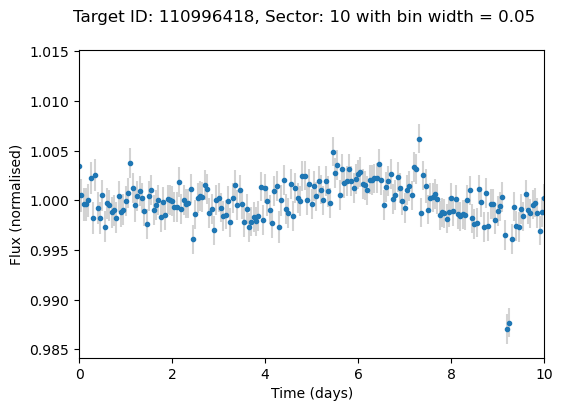

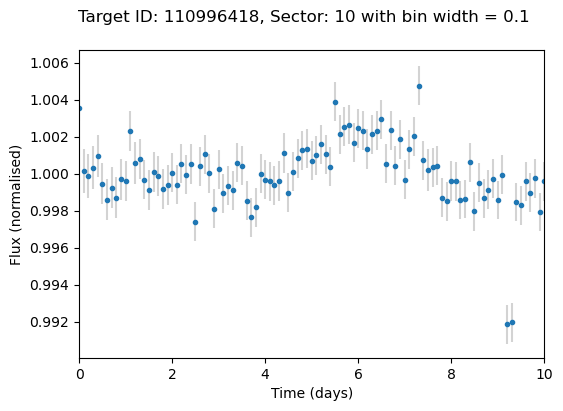

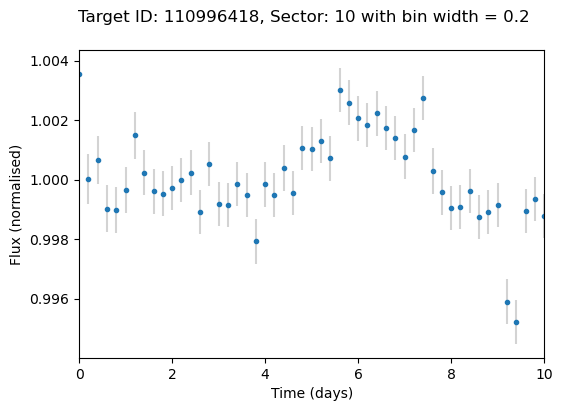

In [11]:
testing_bins = [0.05, 0.1, 0.2]
error_list = compare_bin_errors(testing_curve, testing_bins, cut=(0, 10))
print("\r")
for error_dict in error_list:
    print(f"Bin width {error_dict['bin_width']}, error {error_dict['mean_err']}, std dev {error_dict['std']}")

binned_curves = [testing_curve.bin(time_bin_size=bin_width) for bin_width in testing_bins]

for bin_width, curve in zip(testing_bins, binned_curves):
    plot_curve(curve, folder="pics/binned_comparison/", custom_suffix=f"-bin={bin_width}", x_lim=[0,10], custom_title=f" with bin width = {bin_width}")

From this we can see that there is some long term trend in the data, however the change is within $\pm0.5\%$ so we classify this as purely noise without any other phenomena. We try this method again with a different noisy signal.

66.67%
Bin width 0.05, error 6.468727768971472 electron / s, std dev 16.512138614145776 electron / s
Bin width 0.1, error 4.577245574161527 electron / s, std dev 15.273663470642356 electron / s
Bin width 0.2, error 3.2386127357627927 electron / s, std dev 14.639664700958122 electron / s


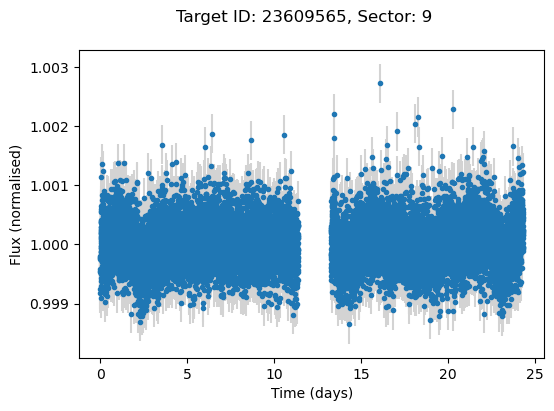

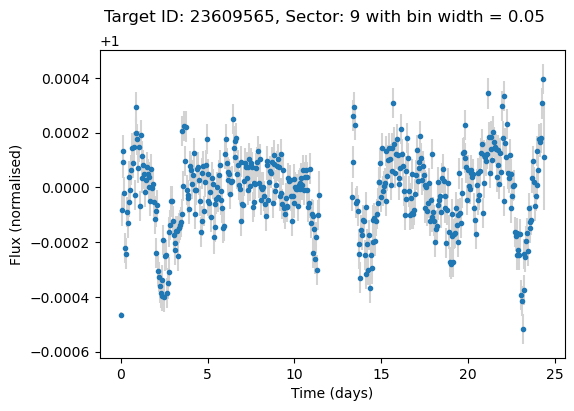

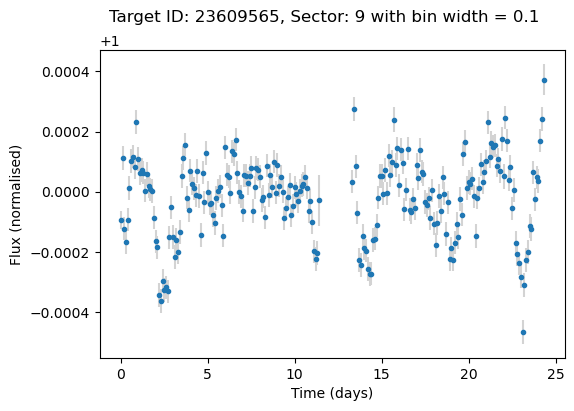

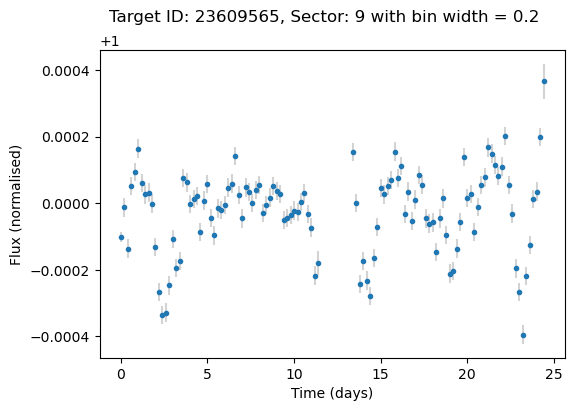

In [12]:
testing_curve = downloaded_curves[27]
plot_curve(testing_curve, save_fig=False)

error_list = compare_bin_errors(testing_curve, testing_bins)
print("\r")
for error_dict in error_list:
    print(f"Bin width {error_dict['bin_width']}, error {error_dict['mean_err']}, std dev {error_dict['std']}")

binned_curves = [testing_curve.bin(time_bin_size=bin_width) for bin_width in testing_bins]

for bin_width, curve in zip(testing_bins, binned_curves):
    plot_curve(curve, folder="pics/binned_comparison/", custom_suffix=f"-bin={bin_width}", custom_title=f" with bin width = {bin_width}")

We have chosen three stars to analyse, which are:
1. TIC 160708862
2. TIC 169226822
3. TIC 441420236

We can start by binning the data to see how it affects the clarity of the data. For simplicity I will create a new list containing these light curves.

In [13]:
selected_curves = [downloaded_curves[32], downloaded_curves[31], downloaded_curves[29]]

Next we will plot these with different bin widths.

Now analysing curve TID 160708862
Bin width 0.01, error 6.631624353265417 electron / s, std dev 43.979464910843255 electron / s
Bin width 0.02, error 4.686841588221542 electron / s, std dev 43.35409861831862 electron / s
Bin width 0.03, error 3.824321241969953 electron / s, std dev 42.797239961372966 electron / s
Now analysing curve TID 169226822
Bin width 0.01, error 7.381814369005759 electron / s, std dev 43.32433846990897 electron / s
Bin width 0.02, error 5.216590644805595 electron / s, std dev 42.66624758376479 electron / s
Bin width 0.03, error 4.256085636632396 electron / s, std dev 42.10982772261365 electron / s
Now analysing curve TID 441420236
Bin width 0.01, error 22.86060253589366 electron / s, std dev 4141.917911488844 electron / s
Bin width 0.02, error 16.403139547356197 electron / s, std dev 4182.690084175776 electron / s
Bin width 0.03, error 13.45609249116352 electron / s, std dev 4199.337195745432 electron / s


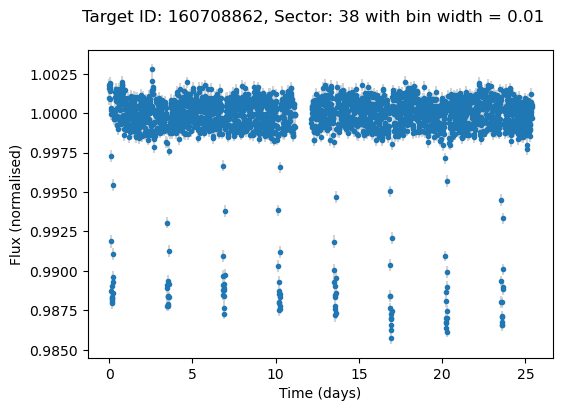

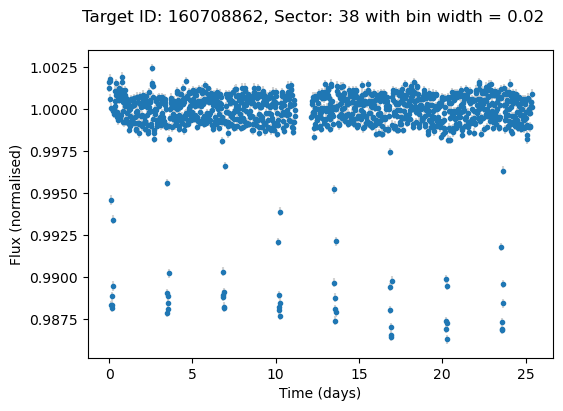

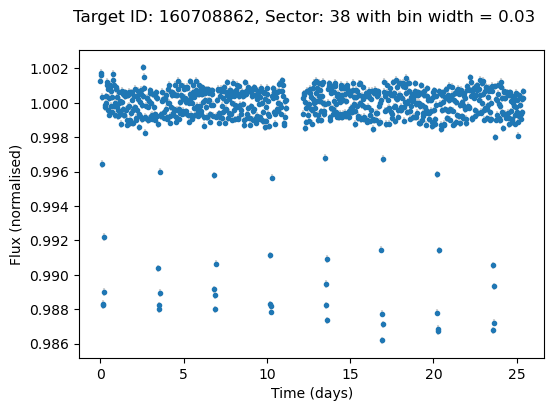

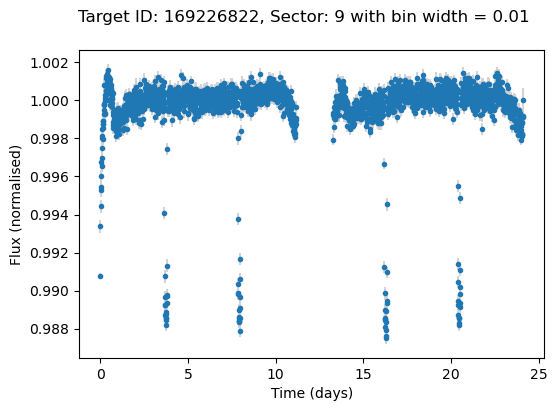

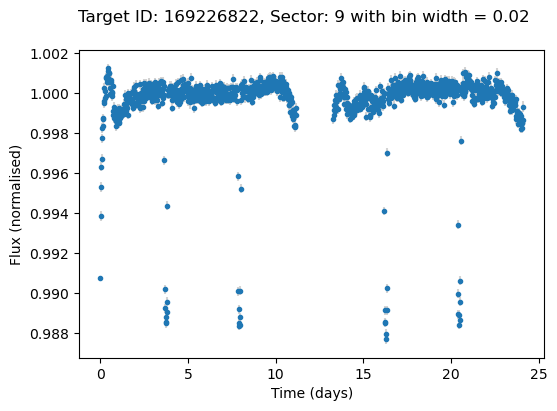

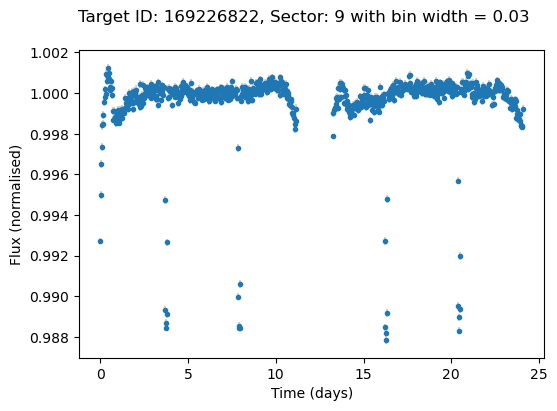

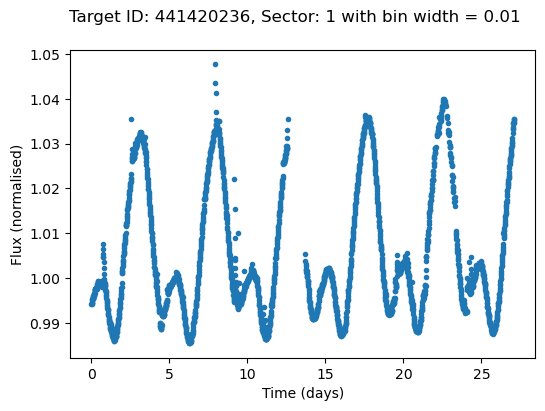

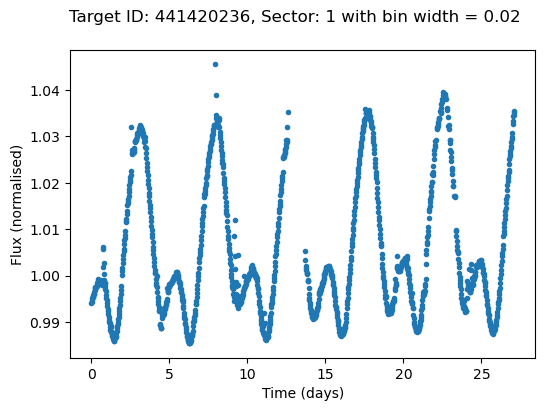

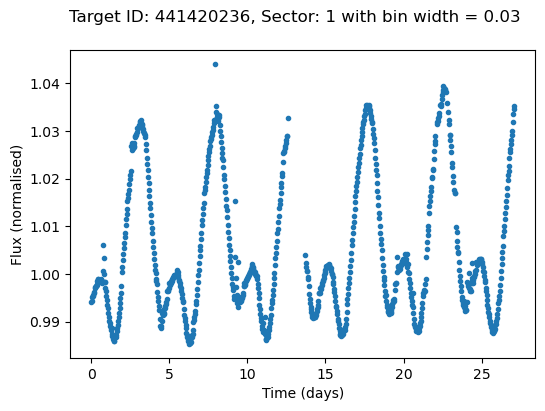

In [14]:
testing_bins = [0.01, 0.02, 0.03]

for curve in selected_curves:
    print(f"Now analysing curve TID {curve.meta['TARGETID']}")
    error_list = compare_bin_errors(curve, testing_bins)
    print("\r", end="")
    for error_dict in error_list:
        print(f"Bin width {error_dict['bin_width']}, error {error_dict['mean_err']}, std dev {error_dict['std']}")

        plot_curve(curve.bin(error_dict['bin_width']), folder="pics/further_analysis/binning/", custom_suffix=f"-bin={error_dict['bin_width']}",
                   custom_title=f" with bin width = {error_dict['bin_width']}")

These are all saved to an appropriate folder to be used in the labbook. Next we wish to investigate how the flags of the data. To do this we first can see which flags are used by the curves:

In [15]:
for flag in np.unique(selected_curves[1].quality):
    print(flag, lk.TessQualityFlags.decode(flag))

0 []
16 ['Argabrightening']
4096 ['Straylight2']
16384 ['Bad Calibration Exclude']
16400 ['Argabrightening', 'Bad Calibration Exclude']
32768 ['Insufficient Targets for Error Correction Exclude']


This shows the values corresponding to each quality key showing the flags in use. We then plot how it changes over each sample.

Text(0, 0.5, 'Quality flag')

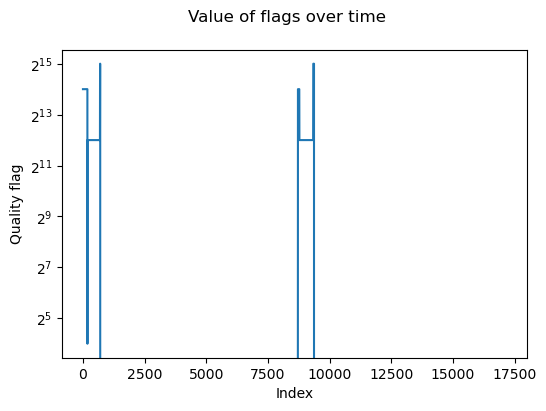

In [16]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_yscale("log", base=2)
ax.plot(np.array(selected_curves[1]["quality"]))
fig.suptitle("Value of flags over time")
ax.set_xlabel("Index")
ax.set_ylabel("Quality flag")

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Time (days)', ylabel='Flux (normalised)'>)

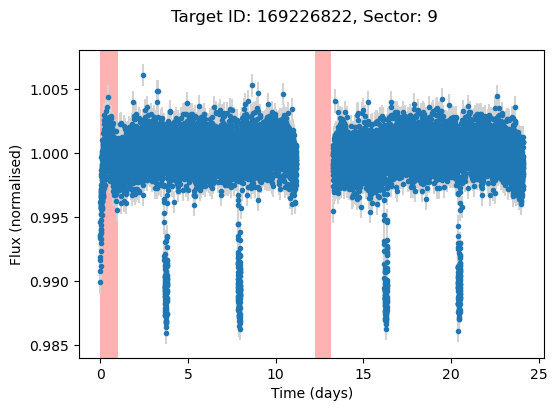

In [17]:
plot_curve(selected_curves[1], save_fig=False, highlight_flags=True)

/var/folders/j3/pj3kpjws5gj32d8zrny204340000gn/T/ipykernel_2055/2618952093.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('gist_rainbow')


(<Figure size 800x500 with 1 Axes>,
 <Axes: xlabel='Time (days)', ylabel='Flux (normalised)'>)

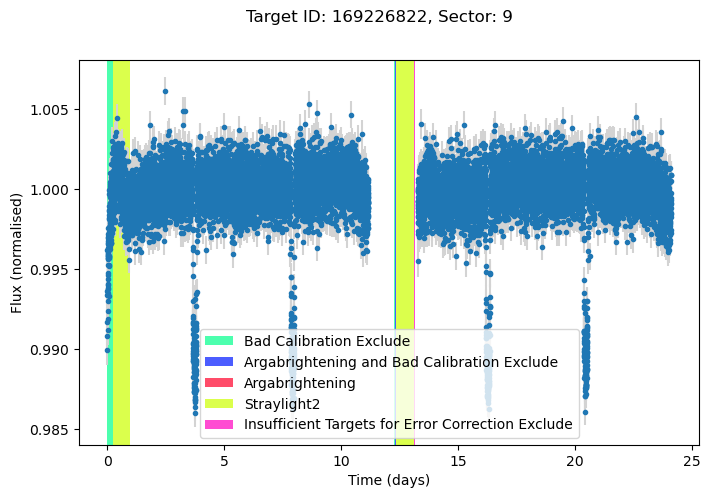

In [18]:
plot_curve(selected_curves[1], save_fig=False, label_flags=True, fig_size=(8,5))

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Time (days)', ylabel='Flux (normalised)'>)

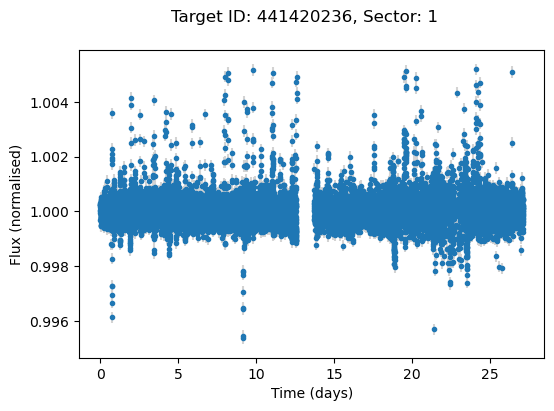

In [19]:
plot_curve(selected_curves[2].flatten(), save_fig=False)

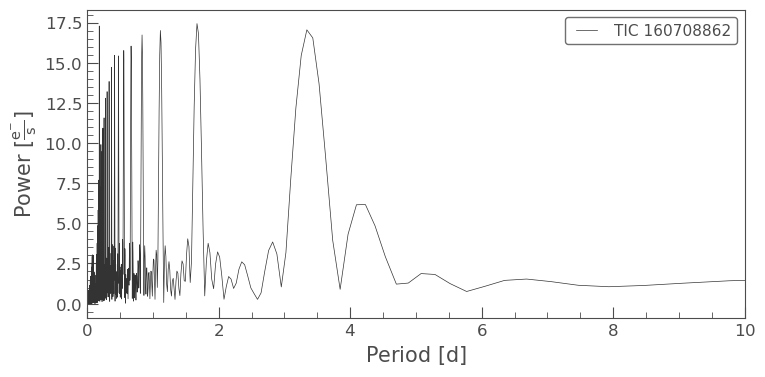

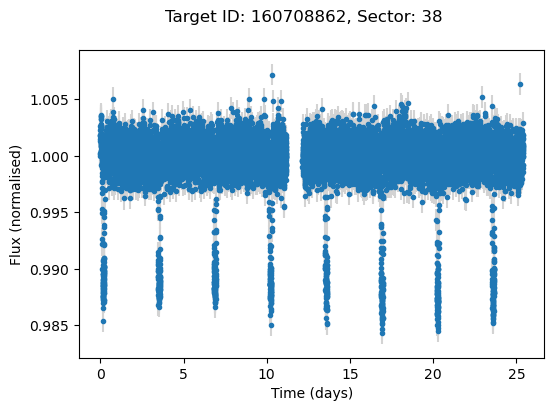

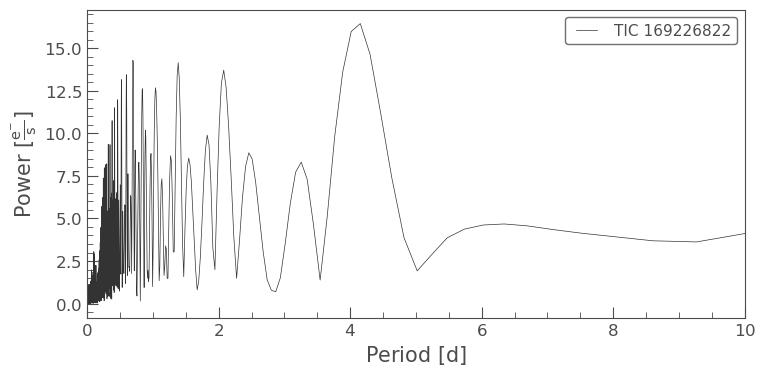

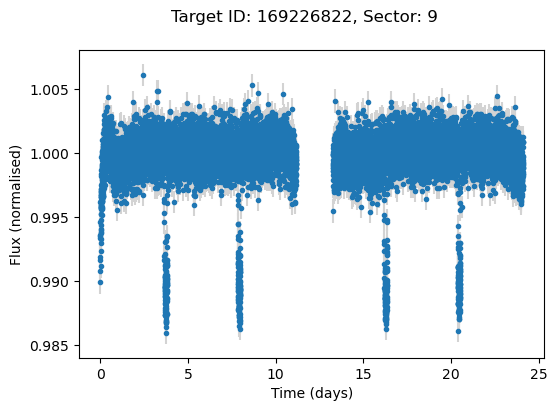

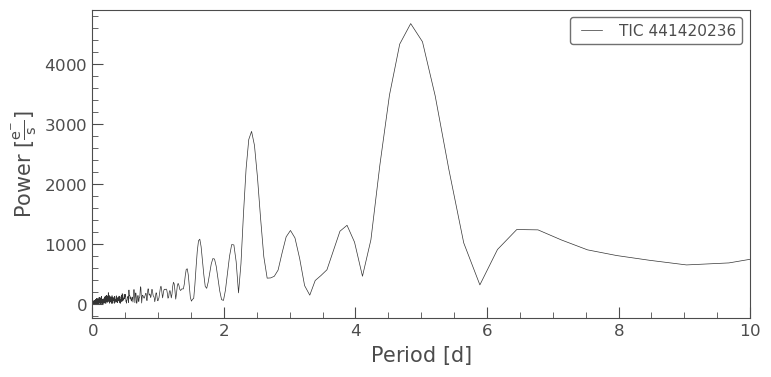

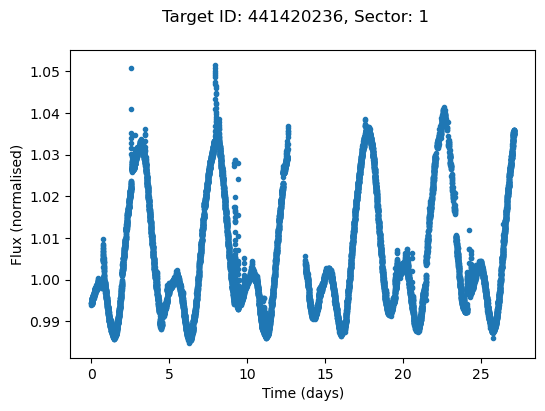

In [20]:
for selected_curve in selected_curves:
    selected_curve.to_periodogram().plot(view="period").set_xlim((0, 10))
    plot_curve(selected_curve, save_fig=False)

(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='Time (days)', ylabel='Flux (normalised)'>)

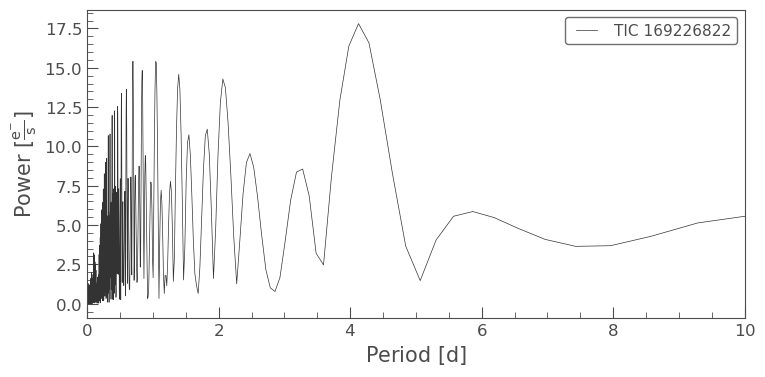

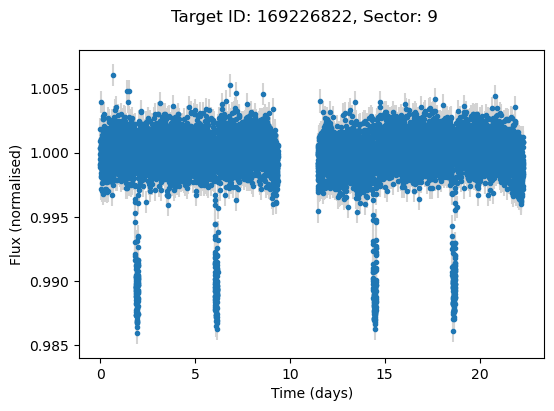

In [21]:
trimmed_curve = selected_curves[1][2000:]
trimmed_curve.to_periodogram().plot(view="period").set_xlim((0, 10))
plot_curve(trimmed_curve, save_fig=False)

(0.0, 10.0)

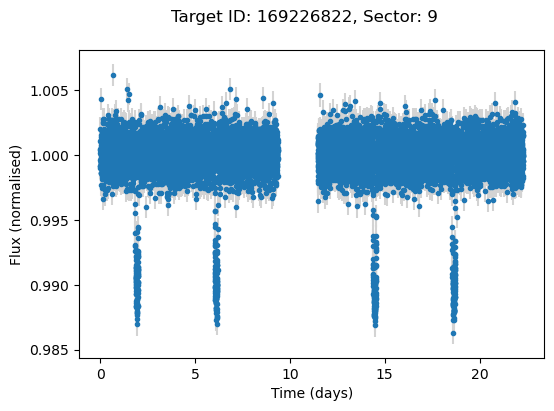

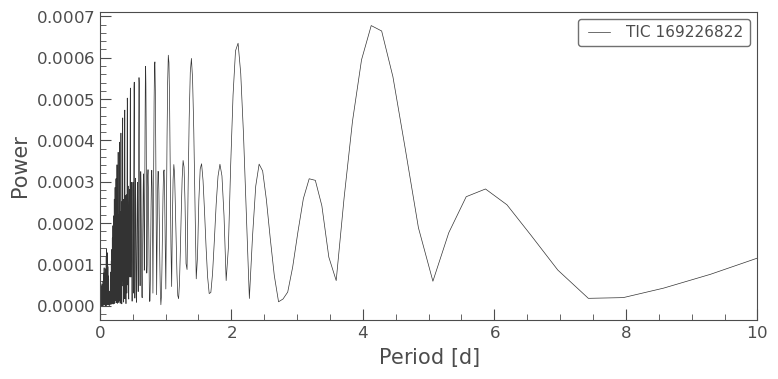

In [22]:
plot_curve(trimmed_curve.flatten(), save_fig=False)
trimmed_curve.flatten().to_periodogram().plot(view="period").set_xlim((0, 10))

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

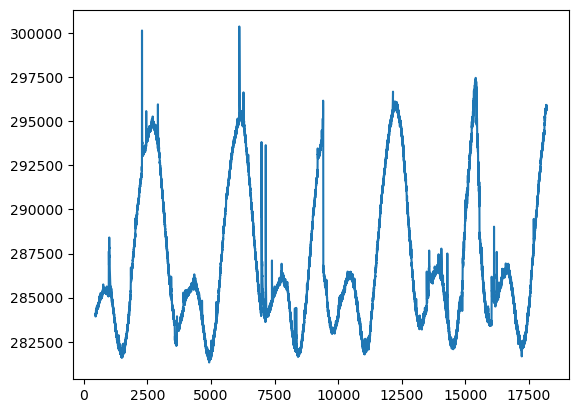

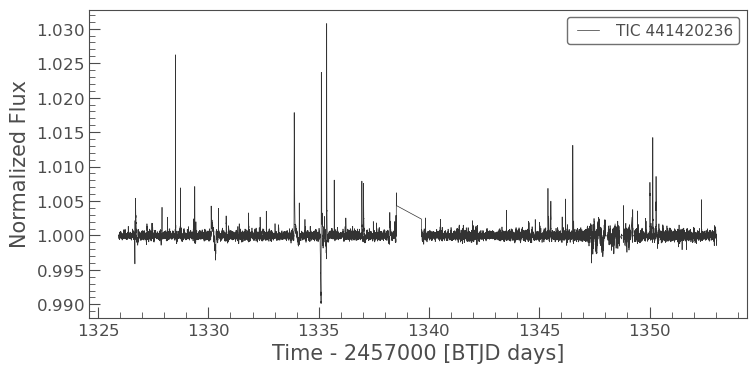

In [23]:
plt.plot(selected_curves[2].flux)
selected_curves[2].flatten(window_length=201).plot()

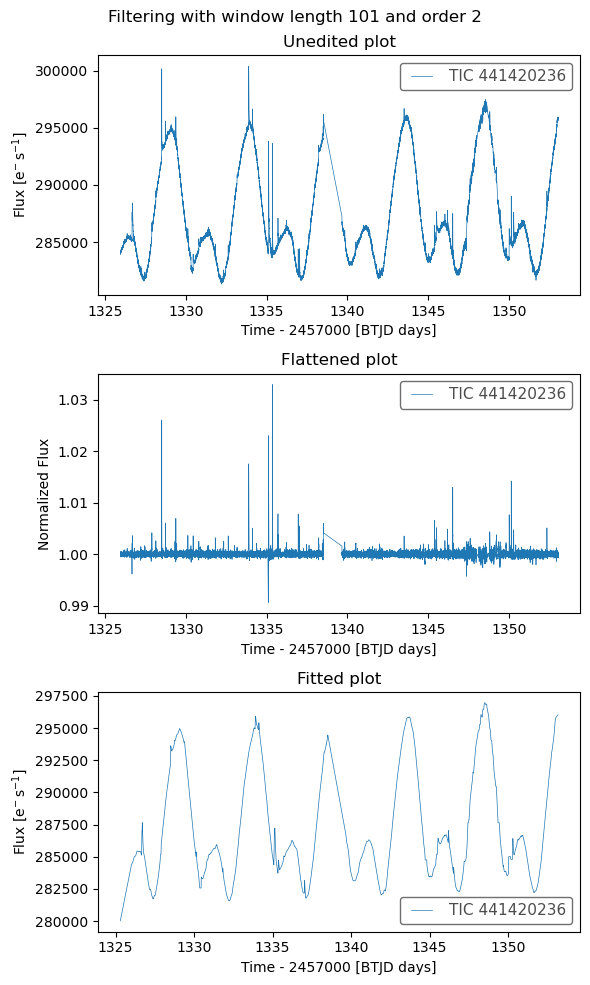

In [24]:
flattened_curve, leftover_curve = selected_curves[2].flatten(window_length=101, polyorder=2, return_trend=True)
# flattened_curve[14000:15000].plot()
# leftover_curve[14000:15000].plot()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,10))

fig.suptitle("Filtering with window length 101 and order 2")

ax1.set_title("Unedited plot")
ax2.set_title("Flattened plot")
ax3.set_title("Fitted plot")

selected_curves[2].plot(ax=ax1)
flattened_curve.plot(ax=ax2)
leftover_curve.plot(ax=ax3)

fig.tight_layout()

plt.show()

1.6706089743869552 d
4.154155407478191 d


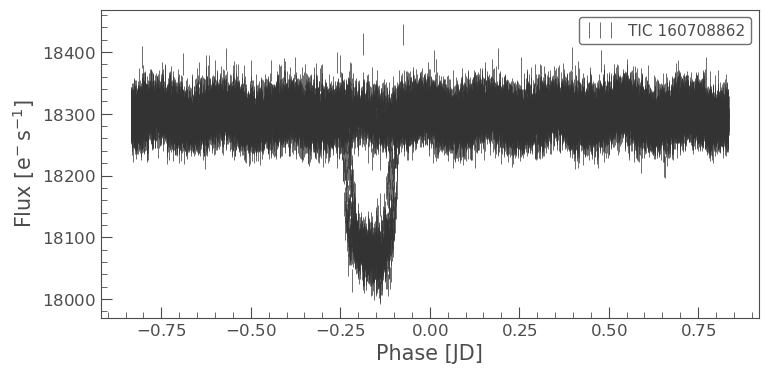

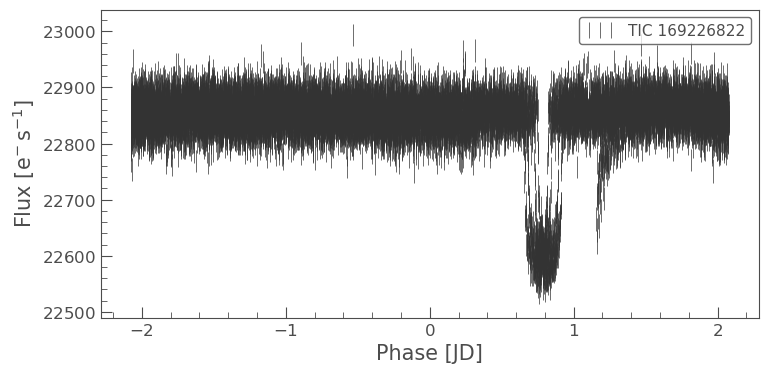

In [25]:
for selected_curve in selected_curves[0:2]:
    selected_periodogram = selected_curve.to_periodogram()
    peak = selected_periodogram.period_at_max_power
    print(peak)
    selected_curve.fold(period=peak).errorbar()

4.177808196427804 d


<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

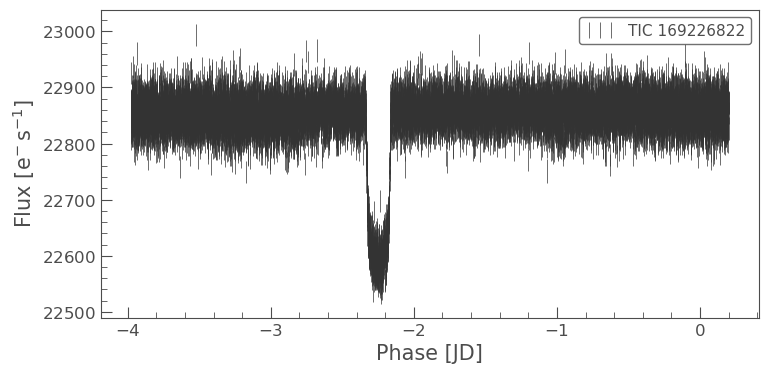

In [26]:
import astropy.units as u


selected_periodogram = selected_curves[1][2000:].to_periodogram(method="bls")
peak = selected_periodogram.period_at_max_power
print(peak)
selected_curves[1][2000:].fold(period=peak, wrap_phase=0.2).errorbar()

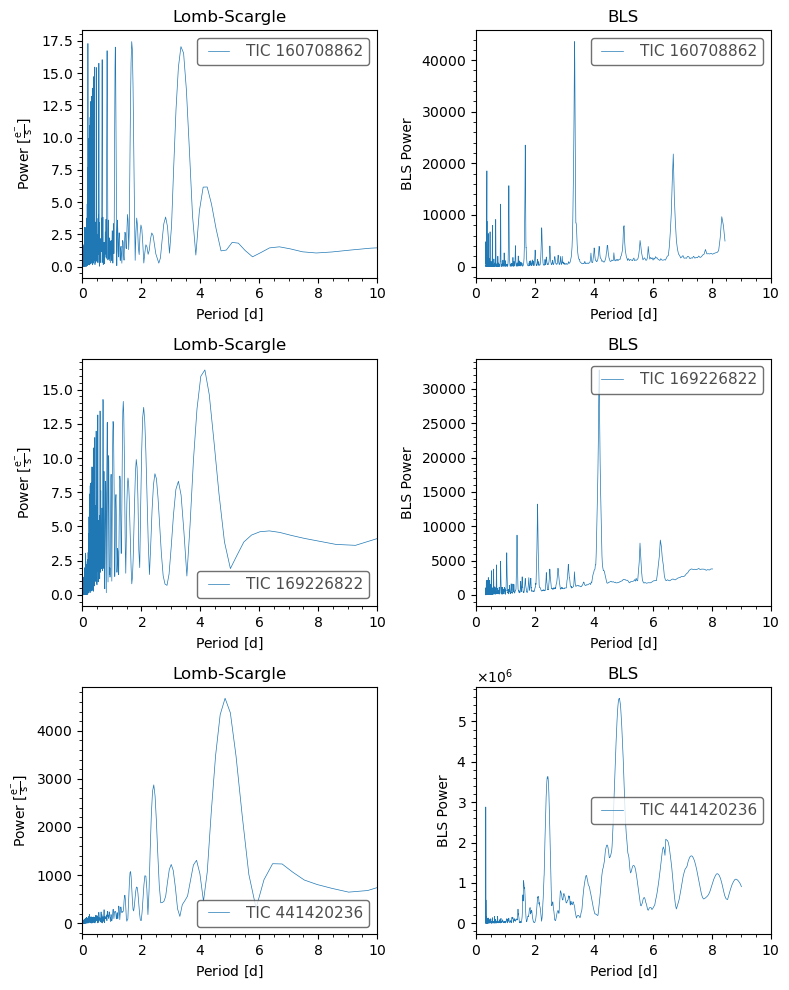

In [27]:
fig, ax = plt.subplots(3,2, figsize=(8, 10))

for selected_curve, ax_i in zip(selected_curves, ax):
    selected_curve.to_periodogram().plot(ax=ax_i[0], view="period").set_xlim((0, 10))
    selected_curve.to_periodogram(method="bls").plot(ax=ax_i[1], view="period").set_xlim((0, 10))
    ax_i[0].set_title("Lomb-Scargle")
    ax_i[1].set_title("BLS")
    # plot_curve(selected_curve, save_fig=False)
fig.tight_layout()

3.3444385824936345 d
4.182579932990049 d
4.863554589616781 d


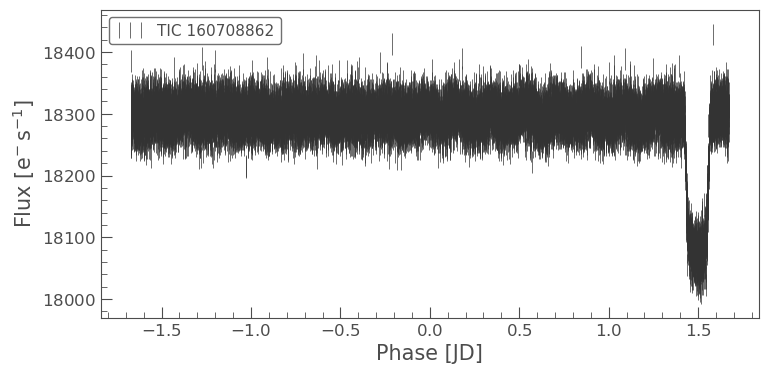

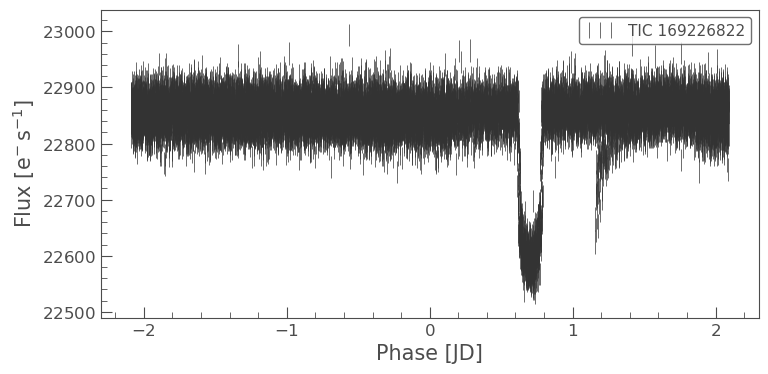

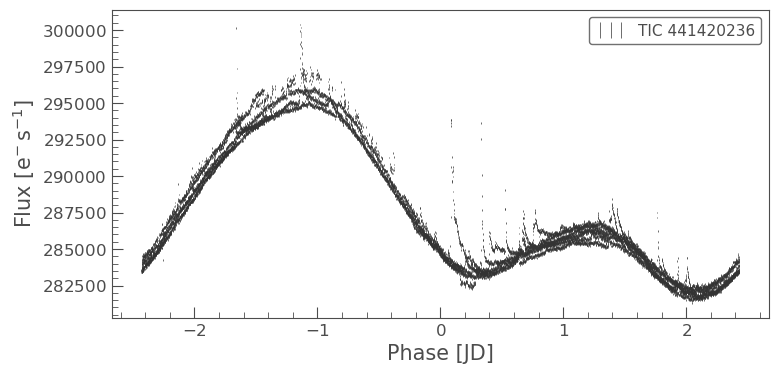

In [28]:
for selected_curve in selected_curves:
    selected_periodogram = selected_curve.to_periodogram(method="bls")
    peak = selected_periodogram.period_at_max_power
    print(peak)
    selected_curve.fold(period=peak).errorbar()

3.3444385824936345 d
4.182579932990049 d
4.863554589616781 d


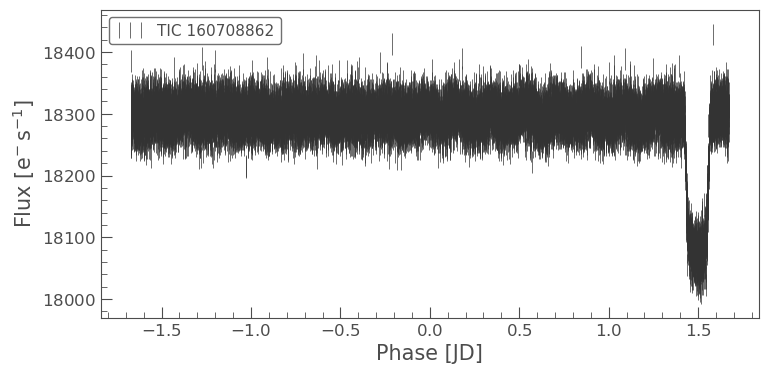

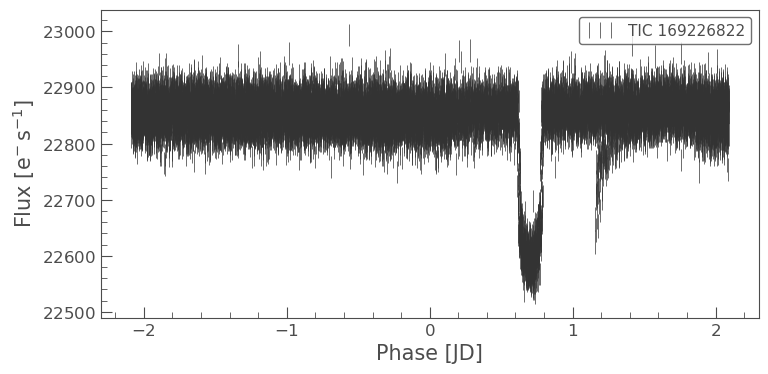

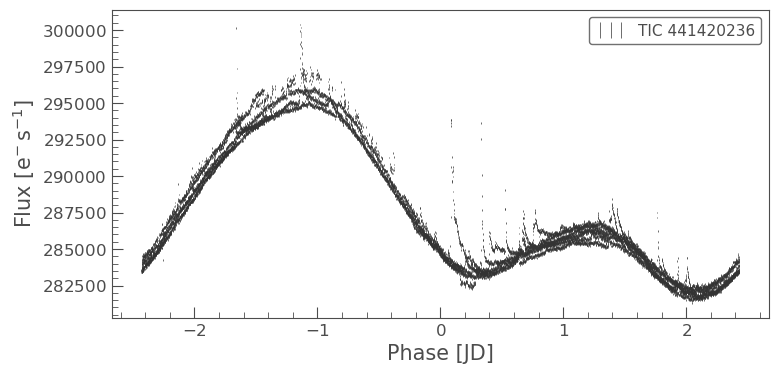

In [29]:
for selected_curve in selected_curves:
    selected_periodogram = selected_curve.to_periodogram(method="bls", oversample=10)
    peak = selected_periodogram.period_at_max_power
    print(peak)
    selected_curve.fold(period=peak).errorbar()

In [30]:
folded_curves = []

for selected_curve in selected_curves:
    selected_periodogram = selected_curve.to_periodogram(method="bls", oversample=10)
    peak = selected_periodogram.period_at_max_power
    print(peak)
    folded_curves.append(selected_curve.fold(period=peak))
    # selected_curve.fold(period=peak).scatter()

3.3444385824936345 d
4.182579932990049 d
4.863554589616781 d


(0.5, 0.9)

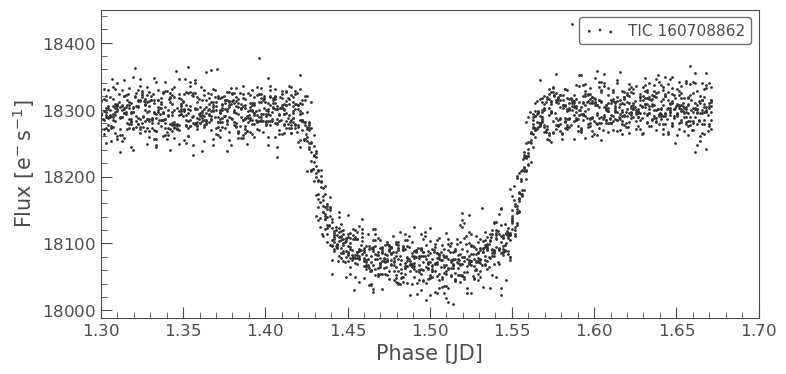

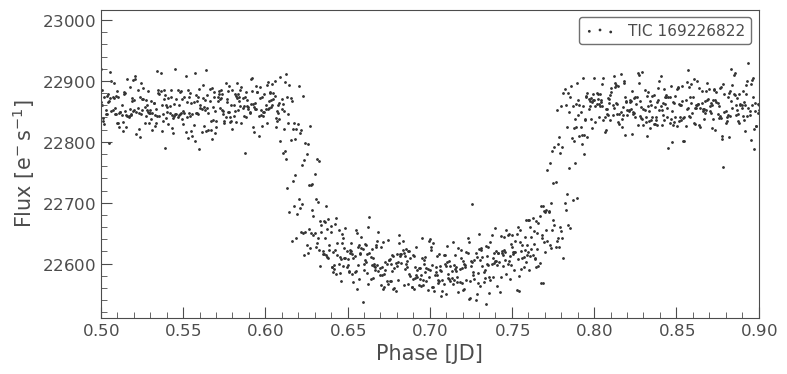

In [31]:
folded_curves[0].scatter().set_xlim(1.3, 1.7)
folded_curves[1].scatter().set_xlim(0.5, 0.9)


No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


(1547.0, 1549.0)

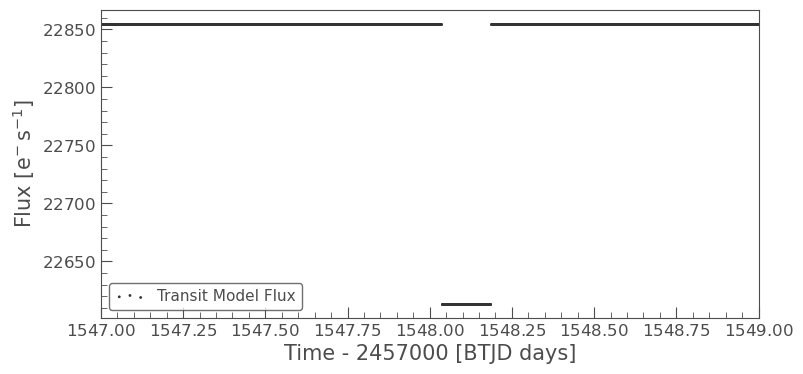

In [32]:
selected_curves[1].to_periodogram(method="bls", oversample=10).get_transit_model().scatter().set_xlim(1547, 1549)
    

In [33]:
# import pytransit
# from pytransit import QuadraticModel

# tm = QuadraticModel()
# tm.set_data(times)

# tm.evaluate(k=0.1, ldc=[0.2, 0.1], t0=0.0, p=1.0, a=3.0, i=0.5*pi)


# tm.evaluate(k=[0.10, 0.12], ldc=[[0.2, 0.1, 0.5, 0.1]], t0=0.0, p=1.0, a=3.0, i=0.5*pi)

# tm.evaluate(k=[[0.10, 0.12], [0.11, 0.13]], ldc=[[0.2, 0.1, 0.5, 0.1],[0.4, 0.2, 0.75, 0.1]],
#             t0=[0.0, 0.01], p=[1, 1], a=[3.0, 2.9], i=[.5*pi, .5*pi])

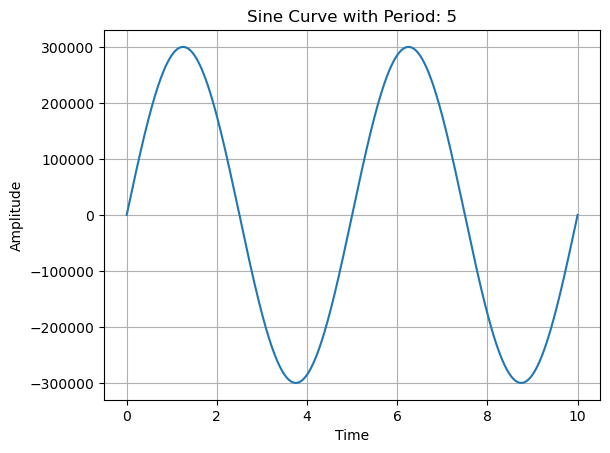

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define the period (time for one complete cycle)
period = 5  # Replace with your desired period
scaling_factor = 300000
# Create a range of time values
t = np.linspace(0, 2 * period, 1000)  # Adjust the number of points as needed

# Calculate the corresponding sine values
sine_wave = np.sin(2 * np.pi / period * t)*scaling_factor

# Plot the sine wave
plt.figure()
plt.plot(t, sine_wave)
plt.title(f'Sine Curve with Period: {period}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [42]:
# Search Kepler data for Quarters 6, 7, and 8.
search_result = lk.search_lightcurve('TESS 2157356', author='Kepler', quarter=(6, 7, 8))
# Download and stitch the data together
lc = search_result.download_all().stitch()
# Plot the resulting light curve
lc.plot();

       time             flux         flux_err       timecorr    cadenceno  centroid_col centroid_row    sap_flux     sap_flux_err     sap_bkg      sap_bkg_err    pdcsap_flux   pdcsap_flux_err     quality      psf_centr1 psf_centr1_err psf_centr2 psf_centr2_err mom_centr1 mom_centr1_err mom_centr2 mom_centr2_err   pos_corr1      pos_corr2   
                    electron / s   electron / s        d                       pix          pix       electron / s   electron / s   electron / s   electron / s   electron / s    electron / s                      pix          pix          pix          pix          pix          pix          pix          pix            pix            pix      
------------------ -------------- -------------- -------------- ---------- ------------ ------------ -------------- -------------- -------------- -------------- -------------- --------------- ---------------- ---------- -------------- ---------- -------------- ---------- -------------- ---------- -------------- -